In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path
import pandas as pd
import numpy as np

from datetime import datetime
import os

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7789773743897622332
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5733613568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10095127475976142947
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
fold_num = 1

# Define dataset paths
data_dir = r'C:\Users\alway\OneDrive\Documents\GitHub\Applied-AI\hw1\dogs-vs-cats\train'

# Image size
img_width, img_height, img_depth = 224, 224, 3

# Training parameters
epochs = 100
freq = 20
batch_size = 32
num_classes = 1  # Binary classification (cats vs. dogs)
train_valid_split = 0.2

# Load the dataset and split it into train and validation sets
all_images = os.listdir(data_dir)
cat_images = [img for img in all_images if 'cat' in img]
dog_images = [img for img in all_images if 'dog' in img]

# Create dataframe for ease of use
data = pd.DataFrame({
    'Image': cat_images + dog_images,
    'Class': ['cat'] * len(cat_images) + ['dog'] * len(dog_images)
})

# Shuffle and split dataset
df_train, df_valid = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

nb_train_samples = int(len(df_train) * (1-train_valid_split))
nb_valid_samples = len(df_train) - nb_train_samples

# class_weights = {0: 2.,
#                 1: 1.,
#                 2: 1.}
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for balancing dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(data['Class']),
    y=data['Class']
)
class_weights_dict = dict(enumerate(class_weights))

# Class mode for binary classification
if num_classes < 2:
    act_type = 'sigmoid'
    class_mode = 'binary'
    loss_fun = 'binary_crossentropy'
else:
    act_type = 'softmax'
    class_mode = 'categorical'
    loss_fun = 'categorical_crossentropy'

print('Type of classification: ', class_mode)
print('Loss function: ', loss_fun)
print('Activation function: ', act_type)
print('Class weights: ', class_weights_dict)

Type of classification:  binary
Loss function:  binary_crossentropy
Activation function:  sigmoid
Class weights:  {0: 1.0, 1: 1.0}


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


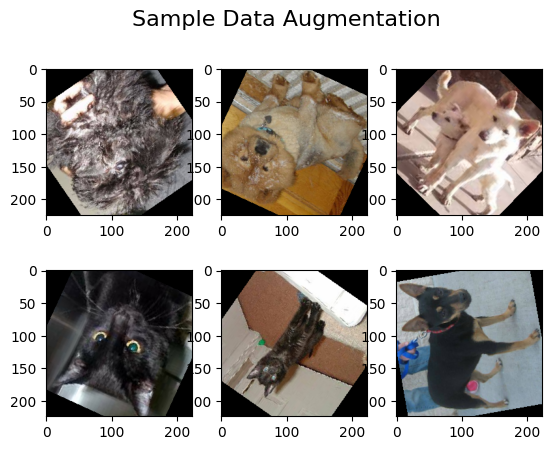

y Labels:  [1. 1. 1. 0.]
sample img, max value:  0.9325695
sample img, min value:  0.0


In [3]:

# ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 90,
    fill_mode = 'constant')

# Train and validation generators
train_generator = datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = data_dir,
    target_size = (img_width, img_height),
    x_col = 'Image',
    y_col = 'Class',
    class_mode = class_mode,
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True)

valid_generator = datagen.flow_from_dataframe(
    dataframe = df_valid,
    directory = data_dir,
    target_size = (img_width, img_height),
    x_col = 'Image',
    y_col = 'Class',
    class_mode = class_mode,
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True)

# Preview the augmented data
X_preview, y_preview = train_generator.next()

for k in range(1, 7):
    sample_img = X_preview[k, :, :, :]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation', fontsize=16)    
plt.show()

print('y Labels: ', y_preview[1:5])
print('sample img, max value: ', np.max(sample_img))
print('sample img, min value: ', np.min(sample_img))

In [4]:
# Build Model using VGG16
image_input = Input(shape=(img_width, img_height, img_depth))
base_model = applications.vgg16.VGG16(input_tensor=image_input,
                                      include_top=False,
                                      weights='imagenet')

base_output = base_model.layers[-1].output

# Custom layers
flat1 = Flatten()(base_output)
fc1 = Dense(8192, activation='relu')(flat1)
dropfc1 = Dropout(0.5)(fc1)
fc2 = Dense(4096, activation='relu')(dropfc1)
dropfc2 = Dropout(0.5)(fc2)

output = Dense(num_classes, activation=act_type)(dropfc2)

# Freeze certain layers in VGG16
for layer in base_model.layers[:-9]:
    layer.trainable = False

model = Model(image_input, output)


In [5]:
# Compile model
opt = Adam(lr=0.00001)
model.compile(loss=loss_fun, optimizer=opt, metrics=['accuracy'])

c:\Users\alway\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
# Initialize time and directory path
init_time = datetime.now()
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = r'.\models\trained_models_' + current_time + '_fold_num' + str(fold_num)

# Create the directory, including intermediate directories if necessary
os.makedirs(name_dir, exist_ok=True)

# Callbacks1: ModelCheckpointer
model_file_format = os.path.join(name_dir, 'model_' + str(fold_num) + '_model.{epoch:04d}.hdf5')
check = ModelCheckpoint(model_file_format, save_freq=freq, verbose=1)

# Callbacks2: TensorBoard
tensor_check = os.path.join(r'./logs/', current_time + '_train_testsplit' + str(fold_num))
tensor_board = TensorBoard(log_dir=tensor_check, write_graph=True)

# Callbacks3: EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

# Plot model
figure_name = os.path.join(name_dir, 'model_output.png')
plot_model(model, figure_name, show_shapes=True)

# Display model
model.summary()


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112

In [8]:
# Load the TensorBoard extension
%load_ext tensorboard

# Start TensorBoard within the notebook
%tensorboard --logdir=./logs --port=6006

# Train model
history = model.fit(train_generator,
                              epochs=epochs,
                              steps_per_epoch=nb_train_samples // batch_size,
                              validation_data=valid_generator,
                              validation_steps=nb_valid_samples // batch_size,
                              callbacks=[check, tensor_board],
                              class_weight=class_weights_dict)

early_stop_name = name_dir + '/fold_num_' + str(fold_num) + 'early_stop_model.hdf5'
model.save_weights(early_stop_name)


Reusing TensorBoard on port 6006 (pid 15672), started 0:03:19 ago. (Use '!kill 15672' to kill it.)

Epoch 1/100
 19/500 [>.............................] - ETA: 1:21 - loss: 0.7922 - accuracy: 0.5312
Epoch 1: saving model to .\models\trained_models_20240907_110208_fold_num1\model_1_model.0001.hdf5
 39/500 [=>............................] - ETA: 3:00 - loss: 0.7449 - accuracy: 0.5681
Epoch 1: saving model to .\models\trained_models_20240907_110208_fold_num1\model_1_model.0001.hdf5
 59/500 [==>...........................] - ETA: 3:03 - loss: 0.6903 - accuracy: 0.6149
Epoch 1: saving model to .\models\trained_models_20240907_110208_fold_num1\model_1_model.0001.hdf5
 79/500 [===>..........................] - ETA: 3:02 - loss: 0.6481 - accuracy: 0.6460
Epoch 1: saving model to .\models\trained_models_20240907_110208_fold_num1\model_1_model.0001.hdf5
 99/500 [====>.........................] - ETA: 3:00 - loss: 0.6102 - accuracy: 0.6739
Epoch 1: saving model to .\models\trained_models_20240907_110208_fold_num1\model_1_model.0001.hdf5
119/500 [======>.......................] - ETA: 2:53 - los

KeyboardInterrupt: 

In [ ]:
# Plot confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
    fig.tight_layout()
    return ax
